In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import joblib
import plotly.express as px

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)

In [2]:
DATA_PATH = "cleaned_features.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()
df

Shape: (1375, 115)


,Gene Name,Accession,Organism,Taxonomy,Molecule_type,Sequence_length,cds_start,cds_end,cds_length,protein length,...,aa_M,aa_N,aa_P,aa_Q,aa_R,aa_S,aa_T,aa_V,aa_W,aa_Y
0,BRCA1,XM_077917536,Podarcis muralis,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,5308,137,4712,4575,1524,...,1.837270,4.002625,5.643045,5.708661,5.511811,12.664042,5.577428,5.052493,0.590551,0.656168
1,BRCA1,XM_028701752,Podarcis muralis,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,4838,137,4760,4623,1540,...,1.818182,3.961039,5.714286,5.649351,5.649351,12.597403,5.649351,5.064935,0.584416,0.649351
2,BRCA1,XM_028701751,Podarcis muralis,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,6869,149,4934,4785,1594,...,1.819322,3.889586,5.646173,5.959849,5.646173,12.609787,5.520703,5.520703,0.815558,0.941029
3,BRCA1,XM_028701750,Podarcis muralis,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,7032,123,5097,4974,1657,...,1.810501,3.862402,5.552203,5.793603,5.672903,12.190706,5.491853,5.612553,0.844900,0.905250
4,BRCA1,XM_028701749,Podarcis muralis,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,7136,137,5201,5064,1687,...,1.896858,3.852993,5.572021,5.749852,5.631298,12.151749,5.394191,5.631298,0.829876,0.889152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,BRCA2,XM_030778157,Chanos chanos,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,6717,0,6717,6717,2238,...,1.653262,3.574620,6.210903,4.512958,6.121537,10.589812,6.300268,5.942806,0.848972,1.340483
1371,BRCA2,XM_030151904,Sphaeramia orbicularis,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,9150,189,9120,8931,2976,...,1.680108,5.107527,5.981183,4.905914,4.099462,11.223118,6.854839,5.947581,0.806452,1.243280
1372,BRCA2,XM_075337343,Anomaloglossus baeobatrachus,Eukaryota;Metazoa;Chordata;Craniata;Vertebrata...,mRNA,9641,20,9521,9501,3166,...,1.926721,5.495894,5.369551,5.053696,5.527479,9.854706,6.253948,6.190777,0.442198,1.389766
1373,BRCA2,XM_075313226,Haematobia irritans,Eukaryota;Metazoa;Ecdysozoa;Arthropoda;Hexapod...,mRNA,3594,187,3304,3117,1038,...,1.926782,8.381503,3.949904,3.179191,4.527938,12.620424,6.165703,4.335260,0.385356,1.348748


In [3]:
#Ensure data consistency
print("\nMissing values per column:")
df.isna().sum().sort_values(ascending=False).head(25)


Missing values per column:


Gene Name    0
kmer_CT      0
kmer_CC      0
kmer_CA      0
kmer_AT      0
kmer_AG      0
kmer_AC      0
kmer_AA      0
codon_GGG    0
codon_GGC    0
codon_GGT    0
codon_GGA    0
codon_GCG    0
codon_GCC    0
codon_GCT    0
codon_GCA    0
codon_GTG    0
codon_GTC    0
codon_GTT    0
codon_GTA    0
codon_GAG    0
codon_GAC    0
codon_GAT    0
codon_GAA    0
codon_CGG    0
dtype: int64

In [4]:
# Identify amino-acid columns (should be aa_A ... aa_V)
aa_cols = [c for c in df.columns if c.startswith("aa_")]

# Metadata columns
meta_cols = [
    "Gene Name", "Accession", "Organism", "Taxonomy", "Molecule_type"
]

# Everything else numeric is a candidate feature
numeric_cols = [
    c for c in df.columns
    if c not in meta_cols and df[c].dtype != "object"
]

print("Metadata columns:", meta_cols)
print("Numeric feature columns:", numeric_cols)
print("Amino Acid columns:", aa_cols)

Metadata columns: ['Gene Name', 'Accession', 'Organism', 'Taxonomy', 'Molecule_type']
Numeric feature columns: ['Sequence_length', 'cds_start', 'cds_end', 'cds_length', 'protein length', 'pct_A', 'pct_T', 'pct_C', 'pct_G', 'GC_content', 'codon_AAA', 'codon_AAT', 'codon_AAC', 'codon_AAG', 'codon_ATA', 'codon_ATT', 'codon_ATC', 'codon_ATG', 'codon_ACA', 'codon_ACT', 'codon_ACC', 'codon_ACG', 'codon_AGA', 'codon_AGT', 'codon_AGC', 'codon_AGG', 'codon_TAA', 'codon_TAT', 'codon_TAC', 'codon_TAG', 'codon_TTA', 'codon_TTT', 'codon_TTC', 'codon_TTG', 'codon_TCA', 'codon_TCT', 'codon_TCC', 'codon_TCG', 'codon_TGA', 'codon_TGT', 'codon_TGC', 'codon_TGG', 'codon_CAA', 'codon_CAT', 'codon_CAC', 'codon_CAG', 'codon_CTA', 'codon_CTT', 'codon_CTC', 'codon_CTG', 'codon_CCA', 'codon_CCT', 'codon_CCC', 'codon_CCG', 'codon_CGA', 'codon_CGT', 'codon_CGC', 'codon_CGG', 'codon_GAA', 'codon_GAT', 'codon_GAC', 'codon_GAG', 'codon_GTA', 'codon_GTT', 'codon_GTC', 'codon_GTG', 'codon_GCA', 'codon_GCT', 'codon_GC

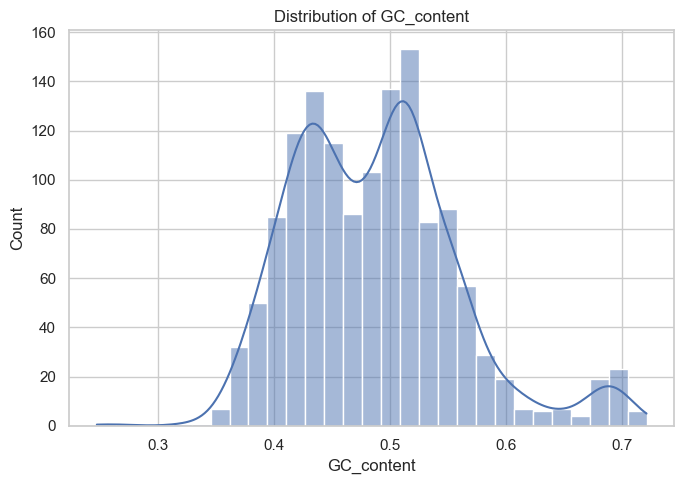

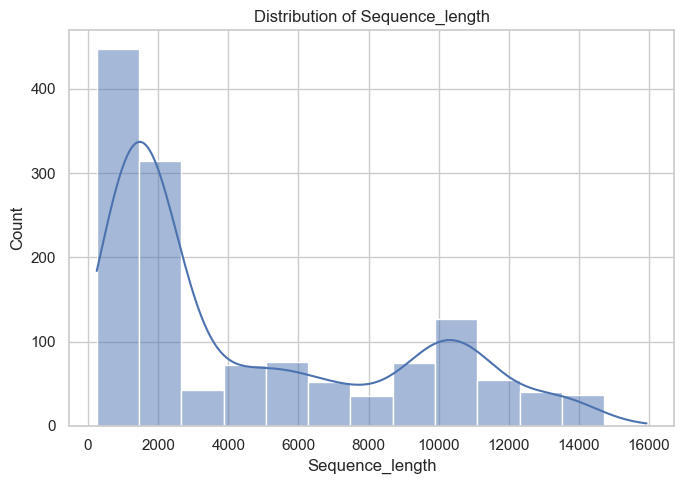

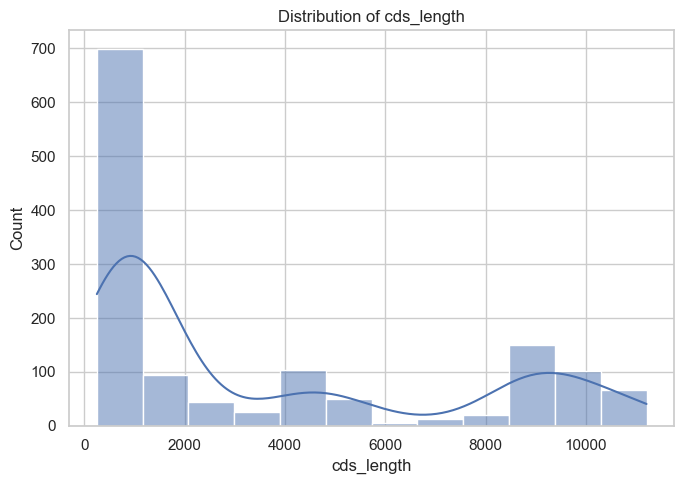

In [5]:
# Inferred key features and their distributions within the dataset
key_features = [
    "GC_content",
    "Sequence_length",
    "cds_length" if "cds_length" in df.columns else None,
    "protein_length" if "protein_length" in df.columns else None,
]
key_features = [f for f in key_features if f is not None]

for feat in key_features:
    plt.figure()
    sns.histplot(df[feat], kde=True)
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


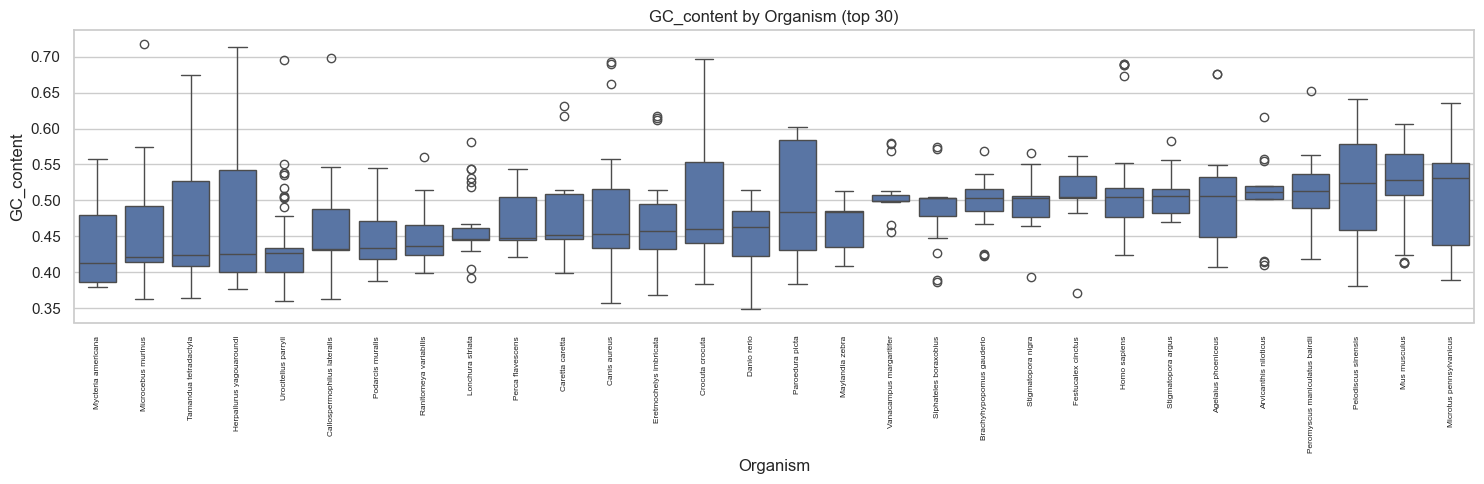

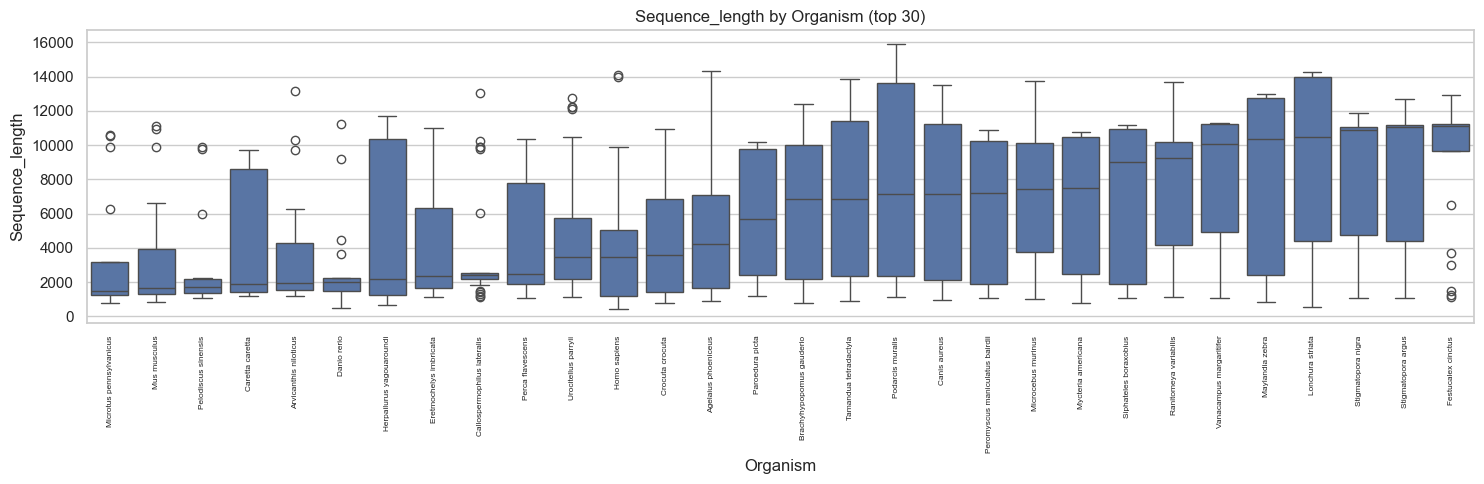

' We initially produced a graph that showed all organisms, but this resulted to be very messy. \n    We updated this to show the top 30 most common organisms which produced much neater plots. '

In [6]:
# If there are many different organisms, sort them and shrink / rotate labels
if "Organism" in df.columns:
    for feat in ["GC_content", "Sequence_length"]:
        # Keeps the top N most common organisms
        top_n = 30
        top_orgs = df["Organism"].value_counts().head(top_n).index
        df_plot = df[df["Organism"].isin(top_orgs)].copy()

        # sorts organisms by median of the feature
        order = (
            df_plot.groupby("Organism")[feat]
                  .median()
                  .sort_values()
                  .index
        )

        # width scales with number of categories
        plt.figure(figsize=(0.5 * len(order), 5))
        sns.boxplot(data=df_plot, x="Organism", y=feat, order=order)

        plt.title(f"{feat} by Organism (top {top_n})")
        plt.xticks(rotation=90, ha="center", fontsize=6)
        plt.tight_layout()
        plt.show()
else:
    print("No 'Organism' column found to group by.")

""" We initially produced a graph that showed all organisms, but this resulted to be very messy. 
    We updated this to show the top 30 most common organisms which produced much neater plots. """


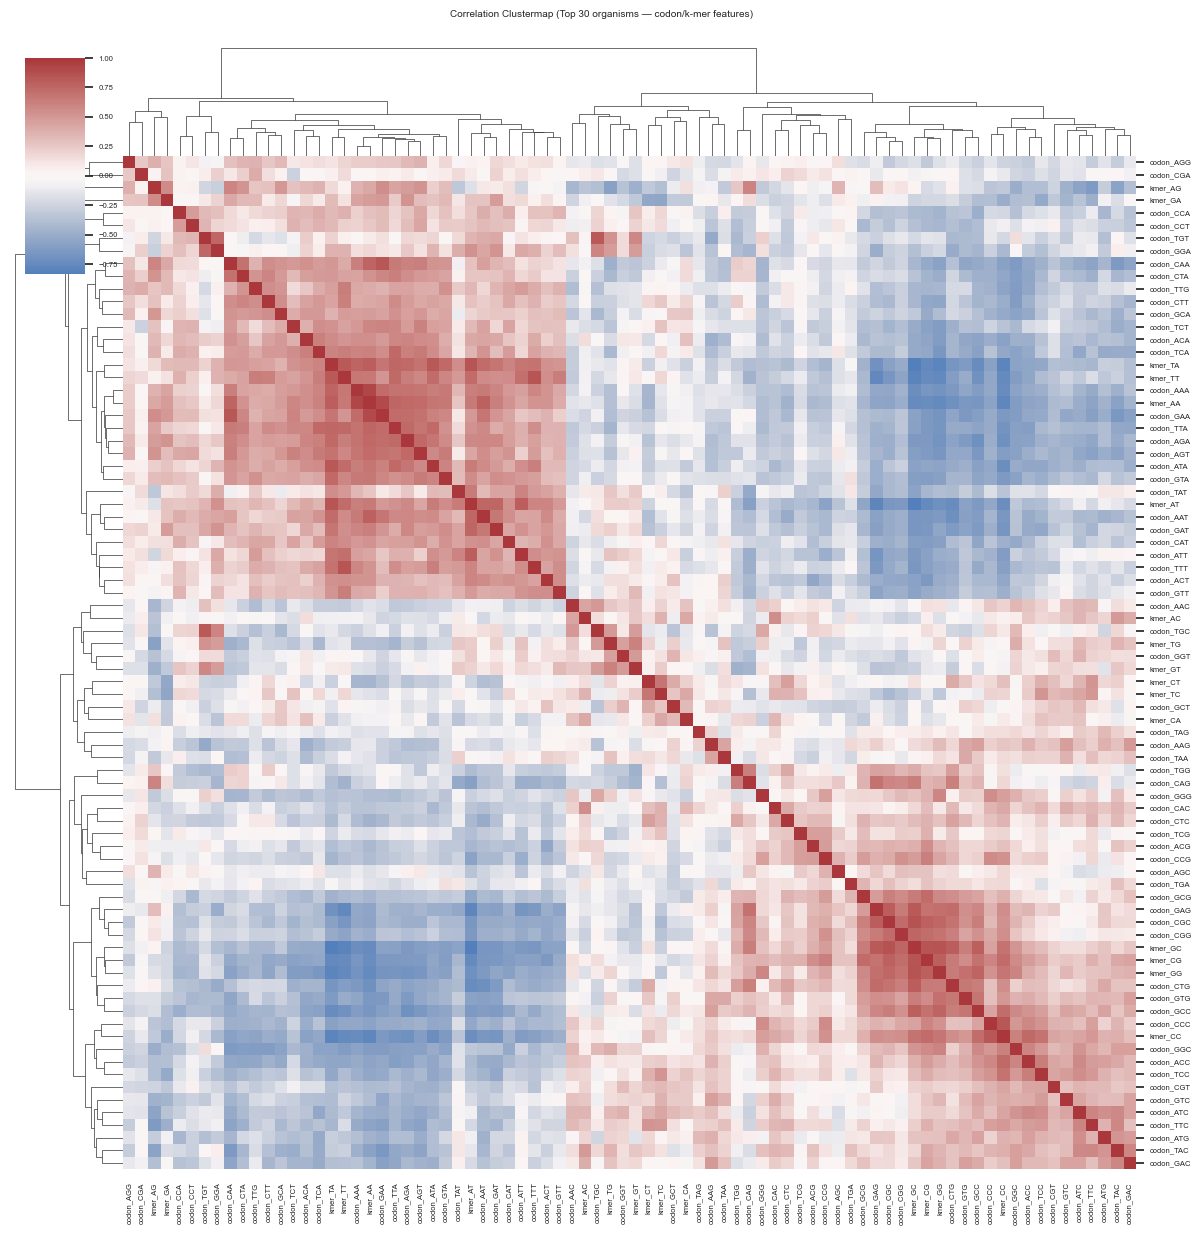

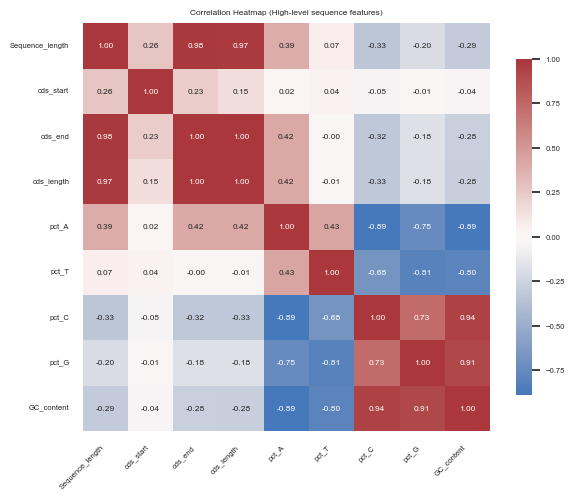

' This heatmap summarizes correlations among broad sequence features such as length, GC content, and nucleotide composition. \nThese features show clear, predictable relationships that reflect fundamental properties of gene structure and provide an interpretable overview of the dataset. '

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 0. Restrict to top 30 organisms (same as before)
# -----------------------------
if "Organism" in df.columns:
    top_30_orgs = df["Organism"].value_counts().head(30).index
    df_top = df[df["Organism"].isin(top_30_orgs)].copy()
else:
    df_top = df.copy()

# All non–AA numeric features
numeric_non_aa = [c for c in numeric_cols if c not in aa_cols]

# -----------------------------
# 1) CODON / KMER HEATMAP (CLUSTERMAP)
# -----------------------------

# codon & k-mer columns (adjust prefixes if yours differ)
codon_like_cols = [
    c for c in numeric_non_aa
    if c.startswith("codon_") or c.startswith("kmer_")
]

corr_codon = df_top[codon_like_cols].corr()

sns.set(font_scale=0.5)  # small labels for many features

g = sns.clustermap(
    corr_codon,
    cmap="vlag",
    center=0,
    figsize=(12, 12),
    dendrogram_ratio=(0.1, 0.1),
    cbar_kws={"shrink": 0.6},
)

g.fig.suptitle(
    "Correlation Clustermap (Top 30 organisms — codon/k-mer features)",
    y=1.02
)
plt.show()

"""Sshows relationships between codon and k-mer composition features, revealing patterns of codon bias and nucleotide preference. 
Codons with similar base composition or encoding the same amino acids tend to cluster together, highlighting redundancy and fine-scale sequence structure.”"""

# -----------------------------
# 2) HIGH-LEVEL FEATURE HEATMAP
# -----------------------------

# pick interpretable high-level features you care about
highlevel_candidates = [
    "Sequence_length", "cds_start", "cds_end", "cds_length",
    "protein_length",
    "pct_A", "pct_T", "pct_C", "pct_G", "GC_content",
    # add mutation-related features here if you have them:
    # "num_mutations", "mutation_rate", ...
]

# keep only those that actually exist in the dataframe & are numeric
highlevel_cols = [c for c in highlevel_candidates if c in df_top.columns]

corr_highlevel = df_top[highlevel_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_highlevel,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.xticks(rotation=45, ha="right")
plt.title("Correlation Heatmap (High-level sequence features)")
plt.tight_layout()
plt.show()

""" This heatmap summarizes correlations among broad sequence features such as length, GC content, and nucleotide composition. 
These features show clear, predictable relationships that reflect fundamental properties of gene structure and provide an interpretable overview of the dataset. """

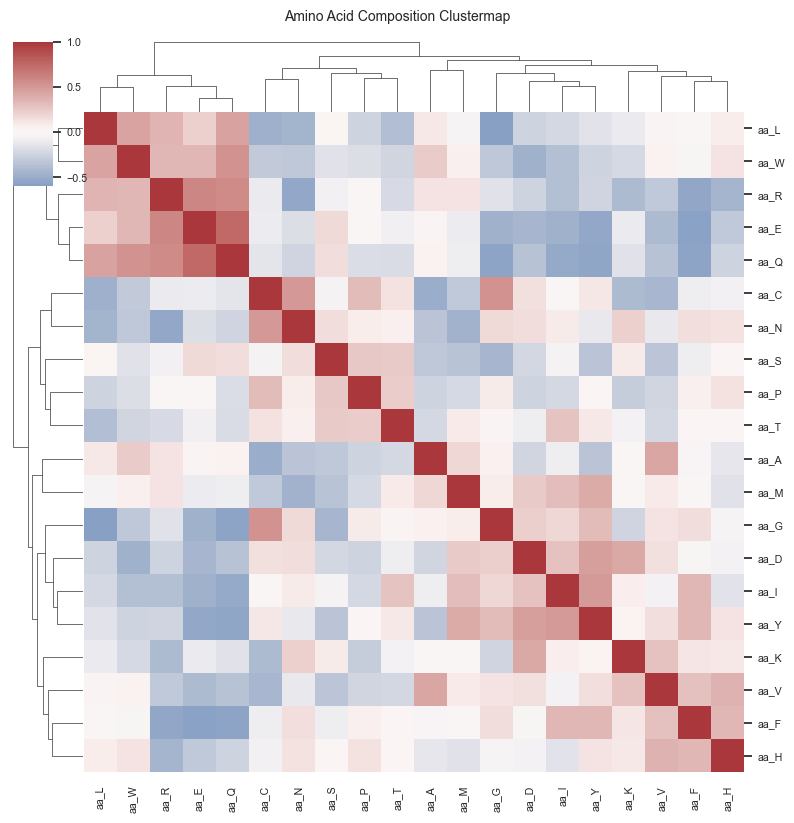

' Shows relationships between amino acid composition features rather than comparing entire sequences.\n    It highlights biological groupings, such as hydrophobic or charged amino acids clustering together. '

In [8]:
# Amino acid feature clustermap (cleaner: feature–feature correlations)
if aa_cols:
    aa_df = df[aa_cols].copy()

    # Correlation between amino-acid composition features
    corr_aa = aa_df.corr()

    sns.set(font_scale=0.7)
    g = sns.clustermap(
        corr_aa,
        cmap="vlag",
        center=0,
        figsize=(8, 8),
        dendrogram_ratio=(0.1, 0.1),
        cbar_kws={"shrink": 0.7},
    )
    g.fig.suptitle("Amino Acid Composition Clustermap", y=1.02)
    plt.show()
else:
    print("No amino-acid columns found (aa_*).")

""" Shows relationships between amino acid composition features rather than comparing entire sequences.
    It highlights biological groupings, such as hydrophobic or charged amino acids clustering together. """


In [9]:
# Use all numeric features for PCA
X = df[numeric_cols].fillna(0).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

'''
Building a PCA DataFrame for plotting, so finding new, uncorrleated variables 
that capture the most information in low dimensionality
'''
function_map = {
    "BRCA1": "DNA Repair",
    "TP53": "Tumor Suppressor",
    "APOE": "Lipid Transport",
    "CFTR": "Ion Channel",
    "FBN1": "Structural Protein",
    "ACTB": "Cytoskeleton",
    "COX1": "Mitochondrial Respiration",
    "RPLP0": "Ribosomal Protein",
    "GAPDH": "Metabolism",
    "HBB": "Oxygen Transport",
    "DMD": "Muscle Structural Protein",
    "HTT": "Neuronal Signaling",
    "BRCA2": "Genome Stability",
    "HPRT1": "Purine Metabolism",
    "B2M": "Immune System"
}

if "Function" not in df.columns:
    df["Function"] = df["Gene Name"].map(function_map)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "PC3": X_pca[:, 2],
    "Function": df["Function"],
    "Gene Name": df["Gene Name"],
    "Organism": df.get("Organism", pd.NA),  # just in case
})
pca_df

Explained variance ratio: [0.26480059 0.12994575 0.06988296]
Cumulative explained variance: [0.26480059 0.39474634 0.46462931]


,PC1,PC2,PC3,Function,Gene Name,Organism
0,4.580356,4.033719,0.391563,DNA Repair,BRCA1,Podarcis muralis
1,4.564194,4.078136,0.364221,DNA Repair,BRCA1,Podarcis muralis
2,4.559679,4.140372,0.429891,DNA Repair,BRCA1,Podarcis muralis
3,4.454326,4.010733,0.380229,DNA Repair,BRCA1,Podarcis muralis
4,4.404746,3.978967,0.384262,DNA Repair,BRCA1,Podarcis muralis
...,...,...,...,...,...,...
1370,3.234581,2.104068,1.157572,Genome Stability,BRCA2,Chanos chanos
1371,6.304278,2.099426,0.873151,Genome Stability,BRCA2,Sphaeramia orbicularis
1372,6.255646,2.601276,0.608975,Genome Stability,BRCA2,Anomaloglossus baeobatrachus
1373,10.261318,1.189644,-1.122249,Genome Stability,BRCA2,Haematobia irritans


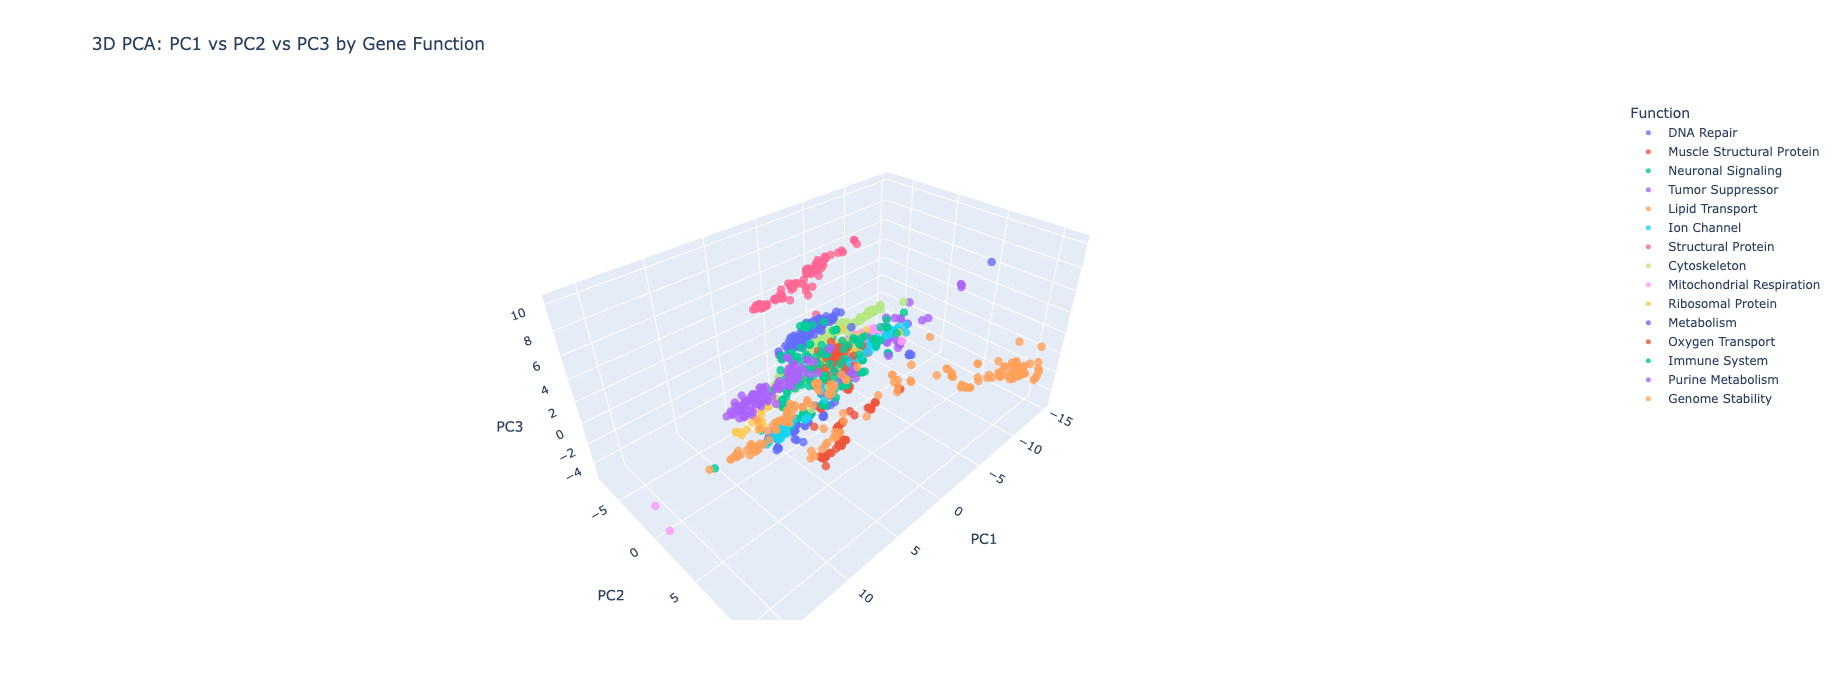

In [10]:
'''
Plotting the PCs to reveal:
- natural structure among genes
- similarities across observations
- potential outliers
- how gene function aligns with PCA space
'''

#PCA colored by Function
fig = px.scatter_3d(
    pca_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Function",
    title="3D PCA: PC1 vs PC2 vs PC3 by Gene Function",
    opacity=0.8,
    height=700
)

fig.update_traces(marker=dict(size=5))
fig.show()

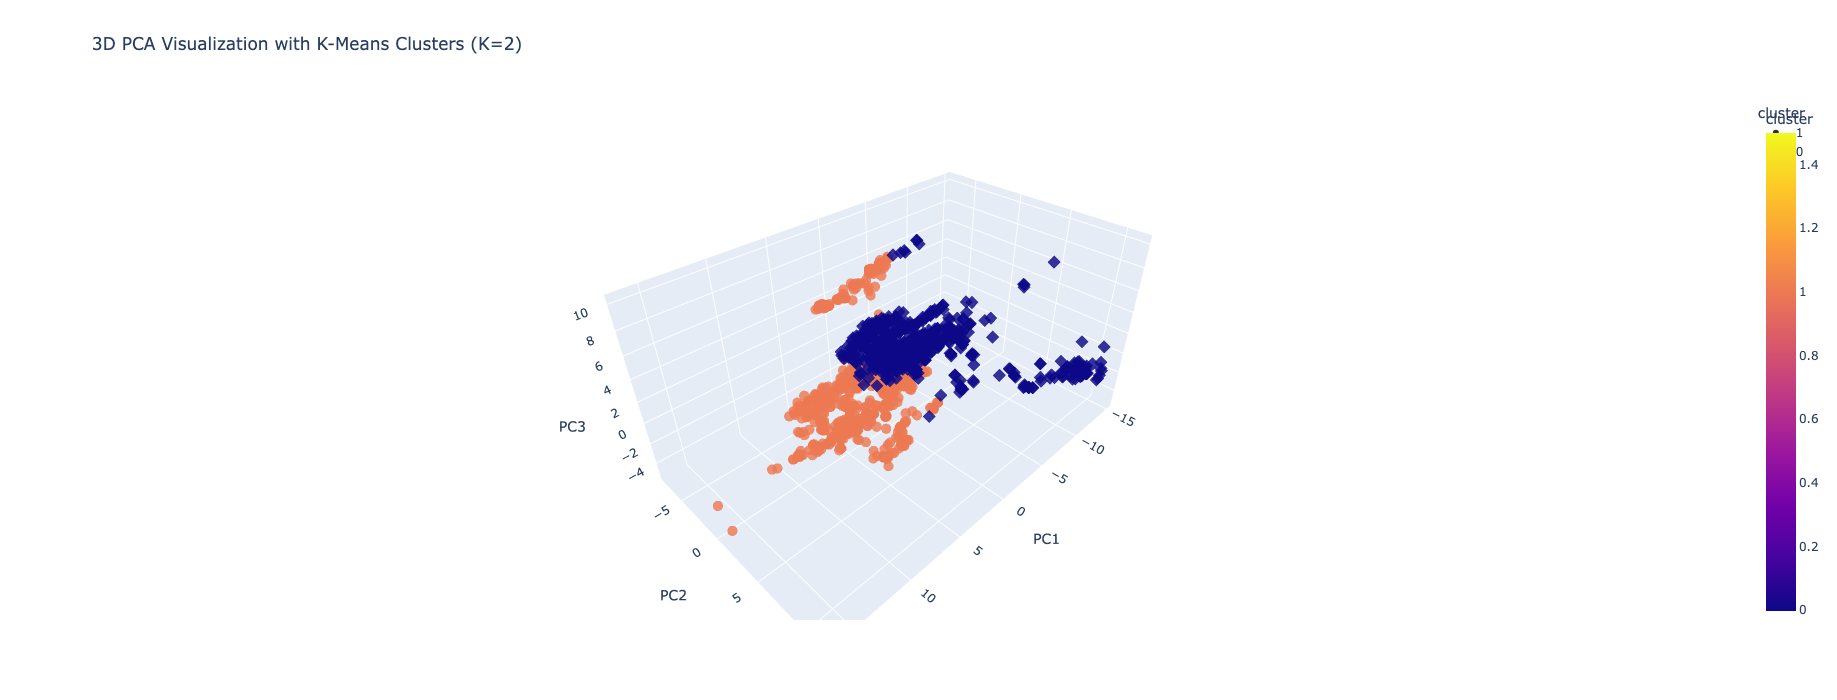

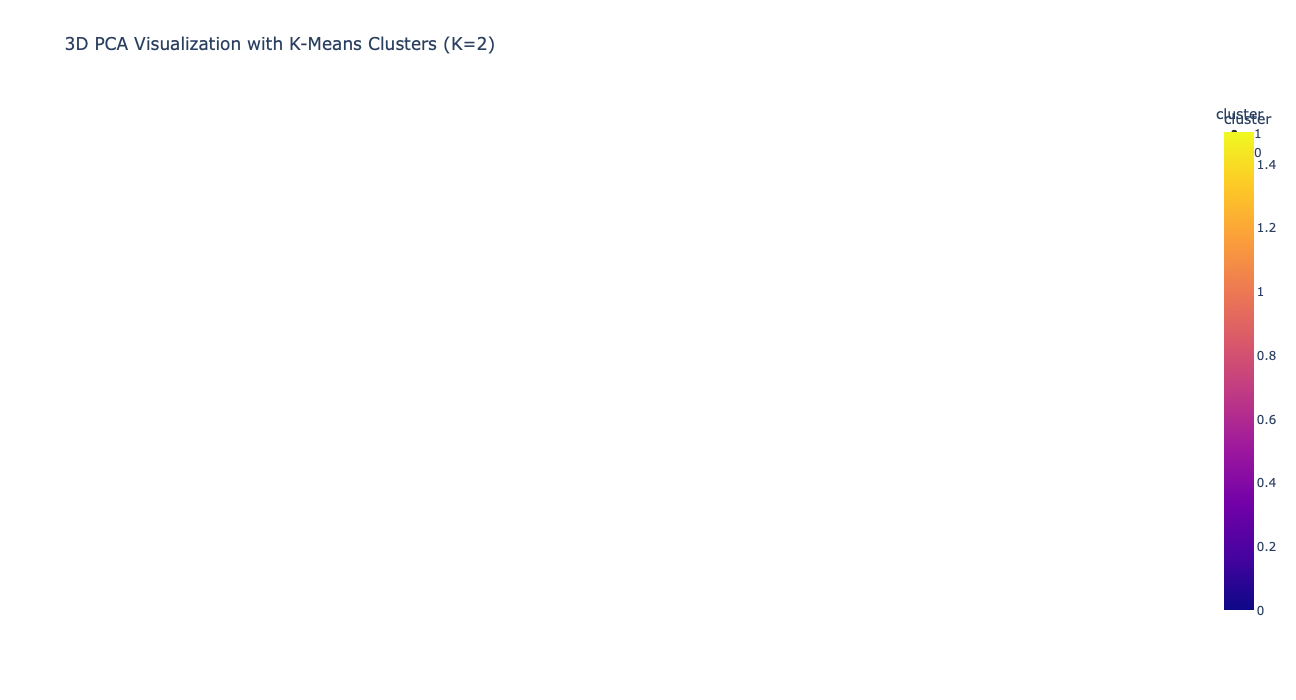

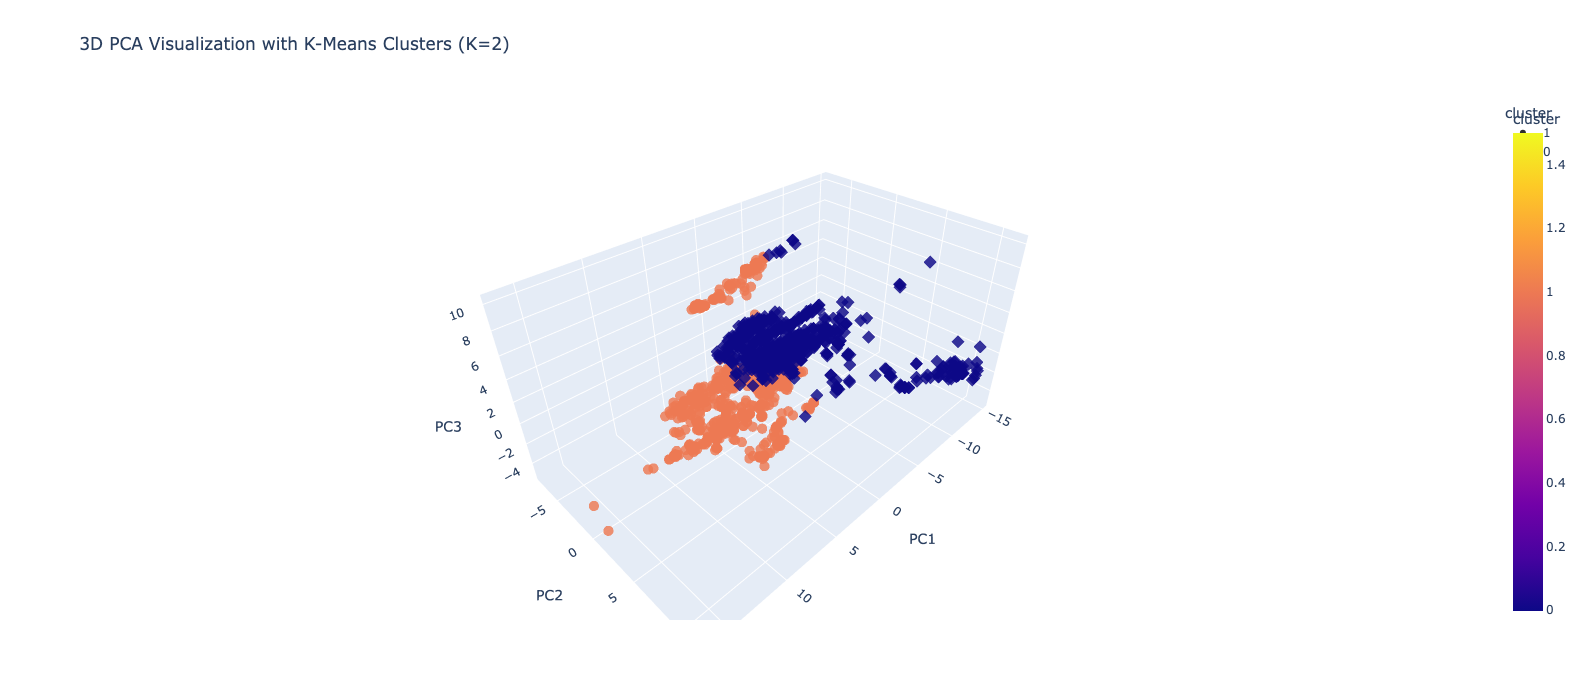

In [11]:
#PCA colored by K-means clusters
K = 2
kmeans = KMeans(n_clusters=K, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X_pca[:, :3])  # use first 3 PCs

pca_df["cluster"] = clusters

fig_cluster = px.scatter_3d(
    pca_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="cluster",
    hover_data=["Gene Name", "Organism", "Function"],
    opacity=0.82,
    symbol="cluster",
    title=f"3D PCA Visualization with K-Means Clusters (K={K})",
    height=700
)

fig_cluster.update_traces(marker=dict(size=6))
fig_cluster.show()
'''
How clusters relate to function, helping us evaluate if clustering reflects
biologically meaningful structure

As expected, the data is split into two dominant "types" of gene feature patterns
in the dataset(Housekeeping Genes vs Specialized Genes)
'''
pca_df[["Function", "cluster"]].value_counts().sort_index().head(20)


In [12]:
# Load the trained model bundle
bundle = joblib.load("models/function_rf.pkl")  # adjust path if needed

model = bundle["model"]
scaler_model = bundle["scaler"]
feature_names = bundle["feature_names"]
le = bundle["label_encoder"]

# Build X for the model from the same feature columns
X_model = df[feature_names].fillna(0)
X_model_scaled = scaler_model.transform(X_model)

# True labels (Function)
y_true = df["Function"]
y_true_encoded = le.transform(y_true)

# Model predictions
y_pred_encoded = model.predict(X_model_scaled)
y_pred = le.inverse_transform(y_pred_encoded)

df["Predicted_Function"] = y_pred

print("true vs predicted functions:")
df[["Gene Name", "Function", "Predicted_Function"]]


true vs predicted functions:


/Users/praneelpothukanuri/Desktop/Rutgers/Intro to DataScience/Final_Proj/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



,Gene Name,Function,Predicted_Function
0,BRCA1,DNA Repair,DNA Repair
1,BRCA1,DNA Repair,DNA Repair
2,BRCA1,DNA Repair,DNA Repair
3,BRCA1,DNA Repair,DNA Repair
4,BRCA1,DNA Repair,DNA Repair
...,...,...,...
1370,BRCA2,Genome Stability,Genome Stability
1371,BRCA2,Genome Stability,Genome Stability
1372,BRCA2,Genome Stability,Genome Stability
1373,BRCA2,Genome Stability,Genome Stability


In [13]:
#Classification report of the model's performance shows strong results
print(classification_report(
    y_true_encoded,
    y_pred_encoded,
    target_names=le.classes_
))

                           precision    recall  f1-score   support

             Cytoskeleton       1.00      1.00      1.00       100
               DNA Repair       1.00      1.00      1.00       100
         Genome Stability       0.99      1.00      1.00       100
            Immune System       0.98      1.00      0.99       100
              Ion Channel       1.00      1.00      1.00       100
          Lipid Transport       1.00      0.98      0.99       100
               Metabolism       1.00      1.00      1.00       100
Mitochondrial Respiration       0.97      1.00      0.98        30
Muscle Structural Protein       1.00      1.00      1.00       100
       Neuronal Signaling       1.00      0.98      0.99       100
         Oxygen Transport       1.00      1.00      1.00        45
        Purine Metabolism       1.00      1.00      1.00       100
        Ribosomal Protein       1.00      1.00      1.00       100
       Structural Protein       1.00      1.00      1.00     

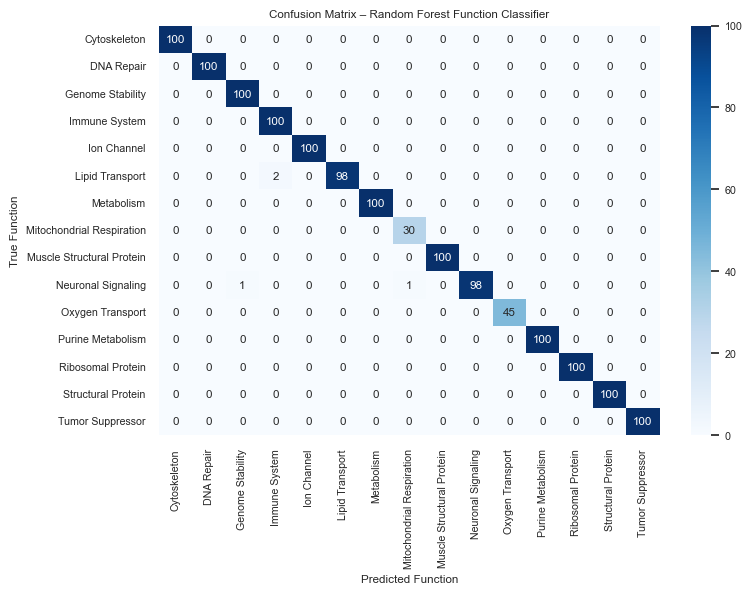

In [14]:
'''
Confusion matrix also shows strong discrimination across all gene functional categories
effectively supporting PCA+clustering findings
'''
cm = confusion_matrix(y_true_encoded, y_pred_encoded)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted Function")
plt.ylabel("True Function")
plt.title("Confusion Matrix – Random Forest Function Classifier")
plt.tight_layout()
plt.show()

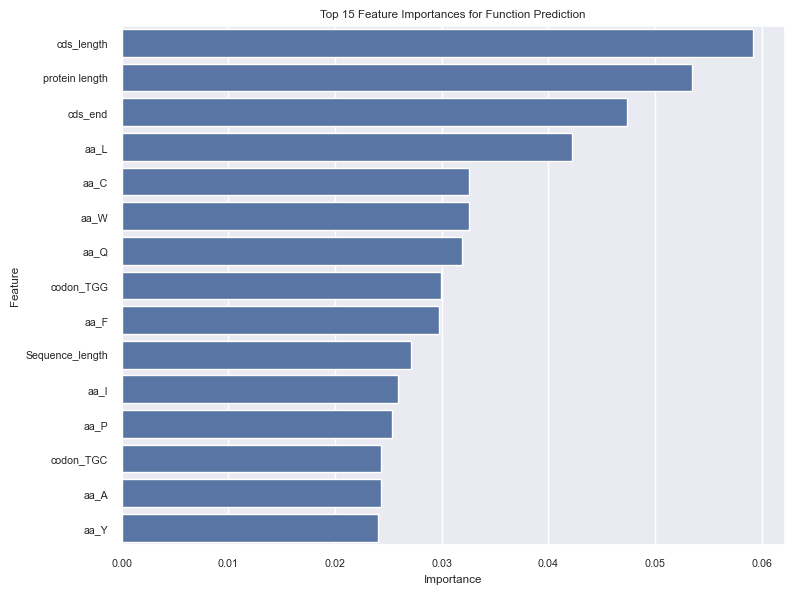

cds_length         0.059196
protein length     0.053467
cds_end            0.047387
aa_L               0.042205
aa_C               0.032604
aa_W               0.032591
aa_Q               0.031920
codon_TGG          0.029972
aa_F               0.029709
Sequence_length    0.027114
aa_I               0.025888
aa_P               0.025379
codon_TGC          0.024325
aa_A               0.024270
aa_Y               0.023998
aa_G               0.023621
codon_ATG          0.023110
aa_H               0.022441
aa_V               0.020479
aa_M               0.020354
dtype: float64

In [15]:
# Horizontal bar chart (importance, feature) to visualize feature importance
importances = model.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    x=fi.head(15),
    y=fi.head(15).index,
    orient="h"
)
plt.title("Top 15 Feature Importances for Function Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

fi.head(20)


In [16]:
# Attaching PCA + cluster + predictions to the main df
df["PC1"] = pca_df["PC1"]
df["PC2"] = pca_df["PC2"]
df["PC3"]= pca_df["PC3"]
df["cluster"] = pca_df["cluster"]

df[["Gene Name", "Function", "Predicted_Function", "cluster", "PC1", "PC2","PC3"]].head(10)

,Gene Name,Function,Predicted_Function,cluster,PC1,PC2,PC3
0,BRCA1,DNA Repair,DNA Repair,1,4.580356,4.033719,0.391563
1,BRCA1,DNA Repair,DNA Repair,1,4.564194,4.078136,0.364221
2,BRCA1,DNA Repair,DNA Repair,1,4.559679,4.140372,0.429891
3,BRCA1,DNA Repair,DNA Repair,1,4.454326,4.010733,0.380229
4,BRCA1,DNA Repair,DNA Repair,1,4.404746,3.978967,0.384262
5,BRCA1,DNA Repair,DNA Repair,1,4.800881,2.705195,-0.834590
6,BRCA1,DNA Repair,DNA Repair,1,4.767207,2.683475,-0.786540
7,BRCA1,DNA Repair,DNA Repair,1,6.828572,3.390274,0.008904
8,BRCA1,DNA Repair,DNA Repair,1,6.847806,3.352613,-0.040415
9,BRCA1,DNA Repair,DNA Repair,1,6.839115,3.366956,-0.015278


Summary:

1. What patterns did the ML model find in gene features?
The Random Forest model picked up on a few features that ended up being really good at separating the different gene functions. The biggest one was protein length, which makes sense because certain types of proteins (like structural vs. metabolic) tend to fall into pretty different size ranges. Amino‑acid composition also showed up as really important, which matches what we know biologically which is proteins with similar roles often have similar chemical makeup. Other sequence‑based features like CDS length and nucleotide percentages helped the model distinguish between gene categories too. Overall, the model wasn’t just guessing as it relied on meaningful biological differences across the genes.

2. How accurate was the model in predicting gene function?
The Random Forest ended up performing extremely well. We got:
Accuracy: 1.00
Precision/Recall/F1: all basically between 0.98 and 1.00
The confusion matrix was almost perfectly diagonal, meaning each gene was consistently assigned to the correct functional group. That tells us our dataset, after feature extraction, separates these ten functions really cleanly, and the model had no trouble learning those boundaries.

3. What does feature importance indicate biologically?
Looking at feature importance, the top features actually make biological sense. An example is that protein length helped separate big functional groups like ribosomal proteins (short) vs. structural proteins (long).Amino‑acid frequencies were strong indicators because proteins involved in similar processes usually share chemical patterns.Even CDS metrics and k‑mer counts helped pick up differences between gene families. So the model wasn’t relying on random correlations which was keying in on patterns that reflect actual functional biology.

4. How did PCA and clustering support the model?
PCA reduced all the high‑dimensional sequence features down to a few components, and even in just two principal components we could already see clear separation between gene functions. When we ran K‑means on those PCA coordinates, the clusters lined up well with the known biological groups. That gives us extra confidence that the structure the model learned is really present in the data as the genes naturally form groups even before running the classifier.